This is a dataset with 10 individuals having a=.25 and b=5. propensities. Surveyed 100 times.
Oddly enough, we only see 3 workers.

The propensities are:

    array([0.109, 0.002, 0.016, 0.023, 0.037, 0.084, 0.001, 0.   , 0.   ,        0.079])
    
The arrival rates:

    array([0.4       , 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
       0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061])

In [1]:
%matplotlib inline
from tqdm import tqdm
import pandas as pd
import numpy as np
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.transforms import t_stick_breaking

/Users/ded/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7201 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:86:00.0)
/Users/ded/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load the data file and specify the number of sampling periods (S)

import pickle
with open('data/gch-10-100-0.25-5.00.pkl', 'rb') as f:
  GCH = pickle.load(f)
S = 100
npdata = np.array(GCH, dtype = int)
V = len(GCH)
V, type(V)

(3, int)

In [3]:
def get_vmask():
    v_mask = np.zeros([S,S,S])
    for s in np.arange(S):
        for q in np.arange(s,S):
            c1 = np.zeros(s)
            c2 = np.ones(q-s)
            c3 = np.zeros(S-q)
            v_mask[s,q]= np.concatenate((c1, c2, c3))
    return tt.constant(v_mask)

In [4]:
def get_imask():
    s_mask = np.zeros([V,S])
    q_mask = np.zeros([V,S])
    for w in np.arange(V):
        f, l = npdata[w, 0] , npdata[w, 1]
        s_mask[w] = np.concatenate((np.ones(f+1), np.zeros(S - f -1)))
        q_mask[w] = np.concatenate((np.zeros(l), np.ones(S-l)))
    i_mask = np.einsum("is,iq->isq", s_mask, q_mask)
    return tt.constant(i_mask)

In [5]:
def get_Risq(a,b):
    tmp_u = npdata[:, 2]
    expanded_u = tmp_u[:, np.newaxis, np.newaxis] *  np.ones((V, S, S)) # V x S x S
    d = np.broadcast_to(np.triu(np.ones([S,S]), 0).cumsum(axis =1), (V, S, S)) # V x S x S
    n = tt.constant(np.clip(d,a_min=0,a_max=S+1))
    n_u = np.triu(d - expanded_u, 0)
    n_u = tt.constant(np.clip(n_u,a_min=0,a_max=max(tmp_u))) # V x S x S
   
    
    # The beta binomial
    R_isq =   tt.gammaln(n+1)
    R_isq -=  tt.gammaln(expanded_u+1)
    R_isq -=  tt.gammaln(n_u+1)   
    R_isq +=  tt.gammaln(expanded_u+a)
    R_isq +=  tt.gammaln(n_u+b)
    R_isq -=  tt.gammaln(n+a+b)
    R_isq +=  tt.gammaln(a+b) - tt.gammaln(a) - tt.gammaln(b)

    # The above is the computation of the log, so we take the exponent
    return tt.exp(R_isq)

In [6]:
def get_Risq0(a,b):
    # n = q - s + 1
    n = tt.constant(np.triu(np.ones([S,S]), 0).cumsum(axis =1))
    R0_sq = tt.gammaln(n + b) - tt.gammaln(n + a + b) + tt.gammaln(a + b) - tt.gammaln(b)
    return tt.exp(R0_sq)

In [14]:
def logp_capture(arr, phi, a, b, U):
    def ll_capture_f(mycaptures):
        
        # Masks: try to compute these once.
        phi_mask = get_vmask()  # S x S x S . all possible arrivals and departures for the "SURVIVAL"
        i_mask   = get_imask()  # KxK   . matrix with real possible arrival and departures
        R_isq = get_Risq(a, b) #
        R0_sq = get_Risq0(a, b) #
    
        # Likelihood of Capture Li
        phi_v = tt.pow(1-phi, phi_mask)
        phi_v = tt.prod(phi_v, axis=2)
        LD = arr[:, np.newaxis] * phi_v * phi
        LD_isq = tt.mul(LD, i_mask)
        Li = tt.batched_tensordot(LD_isq, R_isq, axes = 2)
        
        # Likelihood of No-Capture L0
        v0_mask = 1 - phi_mask[0] # tihs is reuse
        LD0 = tt.mul(LD, v0_mask)
        L0 = tt.sum(LD0 * R0_sq)
        
        # Multinomial
        obj1 = tt.gammaln(tt.constant(V)+U+1.0) - tt.gammaln(U+1.0) - tt.gammaln(tt.constant(V)+ 1.0) #
        obj2 = tt.sum(tt.log(Li))
        obj3 = U * tt.log(L0)

        objective = obj1 + obj2 + obj3 
        
        return objective
    
    return ll_capture_f

In [17]:
birth_init, dep = (np.array([0.4       , 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061,
        0.00606061, 0.00606061, 0.00606061, 0.00606061, 0.00606061]),
 np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1. ]))
for UU in range(0, 100, 1):
    print("Total Unseen:", UU, "/ Likelihood:", logp_capture(birth_init, dep, 0.101,  0.154, UU)(npdata).eval().round(4))

Total Unseen: 0 / Likelihood: -15.629
Total Unseen: 1 / Likelihood: -14.8839
Total Unseen: 2 / Likelihood: -14.6088
Total Unseen: 3 / Likelihood: -14.5568
Total Unseen: 4 / Likelihood: -14.6384
Total Unseen: 5 / Likelihood: -14.8095
Total Unseen: 6 / Likelihood: -15.0453
Total Unseen: 7 / Likelihood: -15.3298
Total Unseen: 8 / Likelihood: -15.6525
Total Unseen: 9 / Likelihood: -16.006
Total Unseen: 10 / Likelihood: -16.3848
Total Unseen: 11 / Likelihood: -16.7848
Total Unseen: 12 / Likelihood: -17.2028
Total Unseen: 13 / Likelihood: -17.6364
Total Unseen: 14 / Likelihood: -18.0834
Total Unseen: 15 / Likelihood: -18.5422
Total Unseen: 16 / Likelihood: -19.0116
Total Unseen: 17 / Likelihood: -19.4902
Total Unseen: 18 / Likelihood: -19.9772
Total Unseen: 19 / Likelihood: -20.4718
Total Unseen: 20 / Likelihood: -20.9732
Total Unseen: 21 / Likelihood: -21.4809
Total Unseen: 22 / Likelihood: -21.9942
Total Unseen: 23 / Likelihood: -22.5128
Total Unseen: 24 / Likelihood: -23.0362
Total Unseen

In [8]:
# custom log-liklihood
# model
with pm.Model() as model:
    # parameters
    U = pm.DiscreteUniform('Unseen', lower=V, upper=5*S)
    a = pm.Uniform('alpha', 0., 1.)
    b = pm.Uniform('beta', 2, 10)
    phi    = pm.Uniform('departure', 0., 1., shape=S)
    arr    = pm.Dirichlet('arrival', a=np.array([1./S]*S), shape=S)
    
    # Model Log-likelihood
    ob = pm.DensityDist('x', logp_capture(arr, phi, a, b, U), observed=npdata)

In [9]:
with model:
  #posterior = pm.sample(3, tune=0, chains=1, progressbar=False)
  #step = pm.NUTS()
  #posterior = pm.sample(100000, step=step, njobs = 4)
  posterior = pm.sample(1000, cores = 1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [Unseen]
>NUTS: [arrival, departure, beta, alpha]
100%|██████████| 1500/1500 [11:35<00:00,  2.16it/s]
There were 941 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2355 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


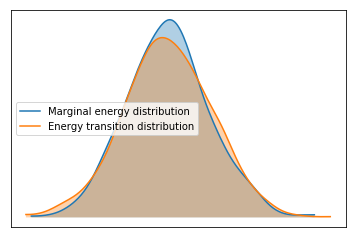

In [10]:
pm.energyplot(posterior);

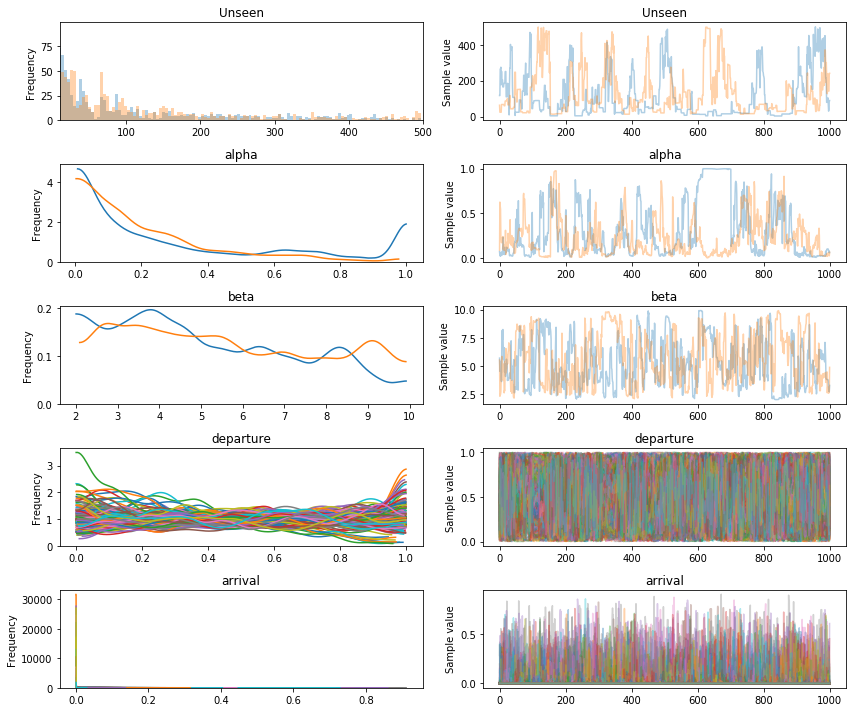

In [11]:
pm.traceplot(posterior);

In [12]:
pm.summary(posterior).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Unseen,117.15,123.88,10.46,3.00,399.00,68.69,1.00
alpha,0.27,0.27,0.02,0.00,0.91,30.68,1.03
beta,5.43,2.21,0.15,2.09,9.28,114.12,1.01
departure__0,0.51,0.30,0.02,0.04,0.98,192.71,1.01
departure__1,0.50,0.30,0.02,0.05,0.99,156.02,1.01
departure__2,0.51,0.28,0.02,0.08,1.00,157.61,1.03
departure__3,0.48,0.29,0.02,0.02,0.97,145.55,1.00
departure__4,0.52,0.28,0.01,0.07,0.99,280.12,1.00
departure__5,0.52,0.28,0.02,0.06,0.99,183.50,1.00
departure__6,0.48,0.29,0.02,0.03,0.97,78.18,1.02
